The measurement of the muon transverse momentum of muons is sensitive to several detector conditions:
   * the *alignment* of the tracker and of the muon chambers
   * the *composition and distribution of the material* inside the tracking volume
   * the knowledge of the *magnetic field* inside and outside the solenoid volume.
<br>

All these conditions affect differently the momentum measurement and can produce biases. In particular, the detector misalignment produces a relative bias that generally increases linearly with the momentum. For this reason it is extremely important to have an accurate knowledge of the tracker and muon spectrometer alignment, and a detailed mapping of the detector material and of the magnetic field. Residual biases can be corrected *a posteriori*, using calibration techniques that generally exploit data from very well-known processes, such as J/&psi;&rarr;&mu;&mu; or Z&rarr;&mu;&mu; decays.

In [99]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import vector
vector.register_awkward()
import ROOT

In [100]:
file=uproot.open('/cms/store/user/hats/Muon/DYJetsToMuMu_M-50_TuneCP5_13TeV-madgraphMLM-pythia8.root')['Events']
#file=uproot.open('~/Downloads/DYJetsToMuMu_M-50_TuneCP5_13TeV-madgraphMLM-pythia8.root')['Events']

In [101]:
muon = ak.Array(ak.zip({"muon_pt":file["Muon_pt"].array(),
                        "muon_eta":file["Muon_eta"].array(),
                        "muon_phi":file["Muon_phi"].array(),
                        "muon_isglobal":file["Muon_isGlobal"].array(),
                        "muon_istracker":file["Muon_isTracker"].array(),
                        "muon_mass":file["Muon_mass"].array(),
                        "muon_charge":file["Muon_charge"].array(),
                        "muon_pfreliso03_chg":file["Muon_pfRelIso03_chg"].array(),
                        "muon_ntrackerlayers":file["Muon_nTrackerLayers"].array(),
                        "muon_genpartidx":file["Muon_genPartIdx"].array(),
                        "genpart_pt":file["GenPart_pt"].array()[file["Muon_genPartIdx"].array()],
                        "genpart_eta":file["GenPart_eta"].array()[file["Muon_genPartIdx"].array()],
                        "genpart_phi":file["GenPart_phi"].array()[file["Muon_genPartIdx"].array()],
                        "genpart_mass":file["GenPart_mass"].array()[file["Muon_genPartIdx"].array()],
                        "genpart_pdgid":file["GenPart_pdgId"].array()[file["Muon_genPartIdx"].array()],
                        "genpart_status":file["GenPart_status"].array()[file["Muon_genPartIdx"].array()],
                        "genpart_statusFlags":file["GenPart_statusFlags"].array()[file["Muon_genPartIdx"].array()]
                       }))

<Array [[32.8, 32.4], ... [65.6, 13.6]] type='306576 * var * float32'>

# Step 1: Generated and reconstructed dimuon Z mass
First, lets reconstruct dimuon z mass.
reapplying previous code. Using the following criteria to select two well-defined and isolated muons. For instance, you can require that both muons pass:<br>

* Muon_genPartIdx!=-1(each muon must have an associated generated particle)
* Muon_isGlobal==1
* Muon_pt>20.
* abs(Muon_eta)<2.4
* Muon_pfRelIso03_chg<0.15

In [102]:
muon_mask=(muon.genpart_pdgid!=-1)& (muon.muon_isglobal==1)& (muon.muon_pt>20)& (abs(muon.muon_eta)<2.4)& (muon.muon_pfreliso03_chg<0.15)

In [103]:
muons_good=muon[muon_mask]

In [104]:
ak.sum((ak.sum(muon_mask,axis=-1)==2))

125698

In [105]:
ak.sum((ak.sum(muon_mask,axis=-1)==3))

96

In [106]:
ak.sum((ak.sum(muon_mask,axis=-1)==1))

94840

Note here if we write a for loop, then 94840 events are don't woth to loop over it. By using columnar method, they can be skipped

In [107]:
ak.sum((ak.sum(muon_mask,axis=-1)==4))

0

In [108]:
ak.sum((ak.sum(muon_mask,axis=-1)==5))

0

In [109]:
ak.sum((ak.sum(muon_mask,axis=-1)==6))

0

We only keep events with 2 good muons. There are 3 events with over 2 muons, we will ignore them for simplicity.

In [110]:
two_good_muons=muons_good[(ak.sum(muon_mask,axis=-1)==2)]

In [111]:
two_good_muons.muon_charge

<Array [[-1, 1], [1, -1], ... [1, -1], [1, -1]] type='125698 * var * int32'>

Lets make sure muons in each event have opposite charge

In [112]:
opposite_sign_muon_mask=(two_good_muons.muon_charge[:,0]!=two_good_muons.muon_charge[:,1])

In [118]:
two_opposite_good_muons=two_good_muons[opposite_sign_muon_mask]
ak.sum(opposite_sign_muon_mask)

125648

In [43]:
two_muon_p4 = ak.Array(ak.zip({"pt":two_opposite_good_muons.muon_pt, 
                               "eta":two_opposite_good_muons.muon_eta, 
                               "phi":two_opposite_good_muons.muon_phi, 
                               "mass":two_opposite_good_muons.muon_mass}), with_name="Momentum4D")

In [44]:
dimuon_p4= two_muon_p4[:,0] + two_muon_p4[:,1]

We can further restrict the selection by requiring the invariant mass is between 70 and 110 GeV

In [45]:
dimuon_mass_mask=(dimuon_p4.M>70)&(dimuon_p4.M<110)

[96.3, 91.9, 93.7, 90.8, 93.3, 91.7, 85, ... 87.6, 86.5, 94.4, 93.1, 91.6, 92.1]


Text(0, 0.5, 'Events')

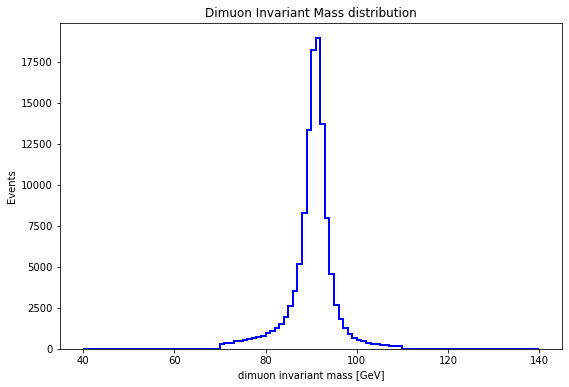

In [46]:
print (dimuon_p4[dimuon_mass_mask].mass)
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4[dimuon_mass_mask].mass, bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

In [48]:
two_gen_muon_p4 = ak.Array(ak.zip({"pt":two_opposite_good_muons.genpart_pt, 
                               "eta":two_opposite_good_muons.genpart_eta, 
                               "phi":two_opposite_good_muons.genpart_phi, 
                               "mass":two_opposite_good_muons.genpart_mass}), with_name="Momentum4D")
two_gen_muon_p4.type

125648 * var * Momentum4D["pt": float32, "eta": float32, "phi": float32, "mass": float32]

In [49]:
gen_dimuon_p4=two_gen_muon_p4[:,0]+two_gen_muon_p4[:,1]

Text(0, 0.5, 'Events')

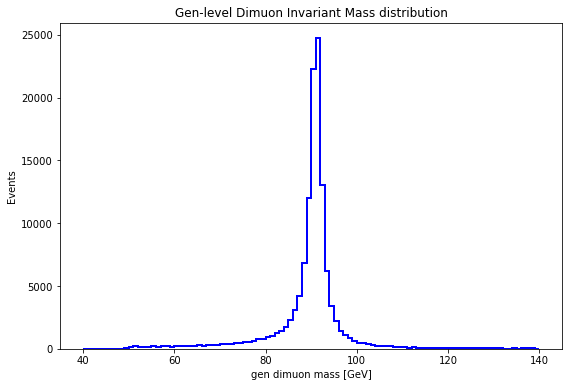

In [50]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

Then, we fit both generated and reconstructed Z mass.<br>
Keep in mind that the Z line shape is not Gaussian, so the Gaussian fit might not be perfect. We then fit them with more suitable functions for each case, e.g. a Breit-Wigner function for the generated mass and a Voigt function (i.e. a convolution of a Breit-Wigner with a Gaussian) for the reconstructed mass. You can easily do this from the ROOT e.g.:

 FCN=486.789 FROM MIGRAD    STATUS=CONVERGED     188 CALLS         189 TOTAL
                     EDM=2.83319e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.89595e+04   1.99220e+02   2.03580e+00  -4.00624e-07
   2  p1           9.10283e+01   5.84779e-03   6.24961e-05  -3.10652e-02
   3  p2           2.79950e+00   1.50550e-02   1.52673e-04  -8.96550e-03


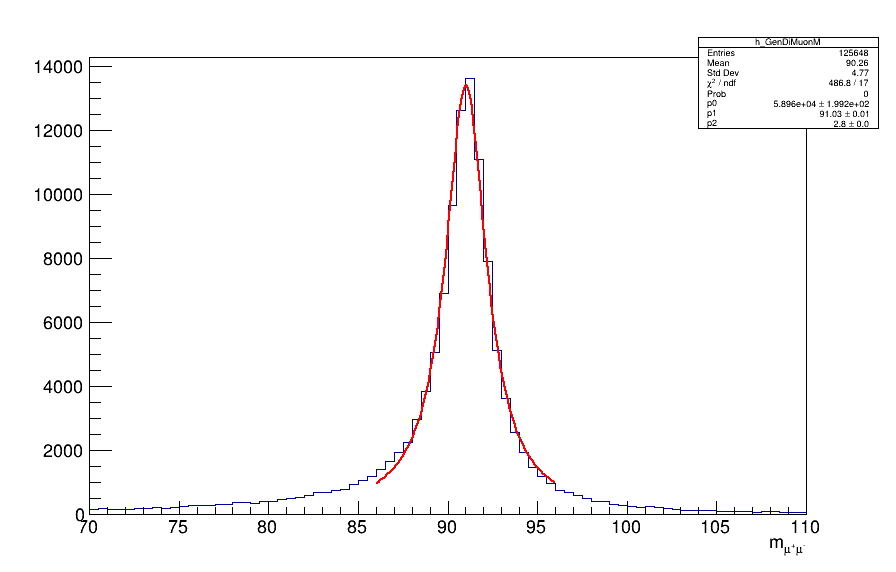

In [51]:
c1 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c1.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c1.Draw()

 FCN=177.844 FROM MIGRAD    STATUS=CONVERGED     314 CALLS         315 TOTAL
                     EDM=1.48497e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.6 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.07964e+04   3.11881e+02   4.25079e-01  -2.59435e-07
   2  p1           9.09636e+01   8.25552e-03   6.08040e-06   1.85739e-03
   3  p2           8.31271e-01   4.15212e-02  -6.42924e-05   3.25748e-03
   4  p3           3.32467e+00   6.25731e-02   1.16766e-04   2.59157e-03


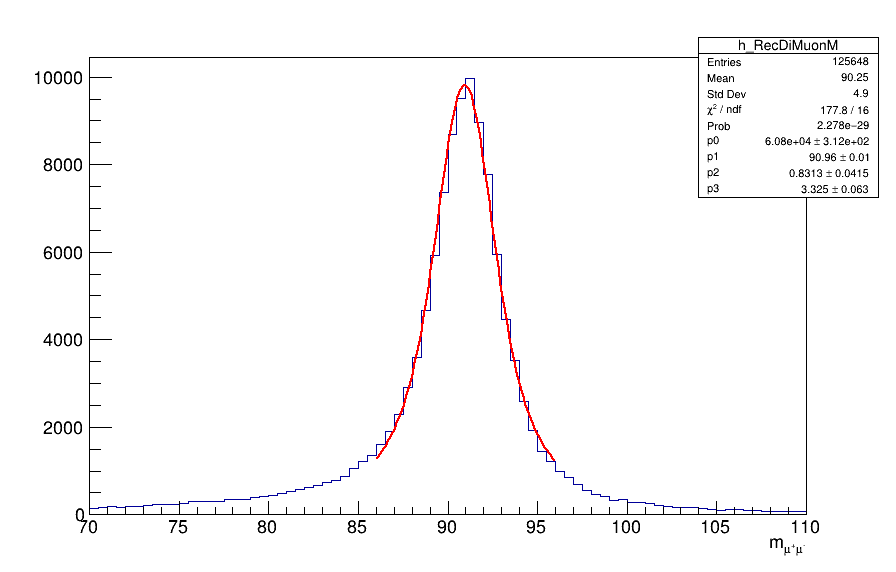

In [52]:
c2 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in dimuon_p4.mass:
    h_RecDiMuonM.Fill(m)
h_RecDiMuonM.Draw()
c2.Draw()
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c2.Draw()

**Questions 1:**
   * Compare the mean values obtained from the fits to the generated and reconstructed distributions. Are they compatible or do they differ significantly? How do they compare to the nominal Z mass value, m<sub>Z</sub> = 91.1876 GeV? Which distribution has the larger shift with respect to m<sub>Z</sub>?
   * Compare the widths of the two distributions (GEN and RECO). Which one is larger? Can you explain why? 
   * Considering that the natural width of the Z boson is &Gamma;<sub>Z</sub> = 2.4952 GeV, can you roughly estimate the typical dimuon mass resolution of Z&rarr;&mu;&mu; events measured with the CMS detector?(*Note:* with a _Voigtian_ fit, you would get an estimate of the  mass resolution directly from the fit) 
   * Why do you need different functions to better fit the generated and reconstructed mass distributions? What differs between the two? If you had to fit the peak of a reconstructed J/&psi; instead, what function would you use, and why?



# Step 2: Investigate the shape of the dimuon mass spectrum
Next, we will create [TProfile histograms](http://root.cern.ch/root/html/TProfile.html) of the reconstructed dimuon invariant mass _vs_ azimuthal coordinate of the muon direction (&phi;), separately for positive and negative muons, as well as the dimuon mass _vs_ pseudorapidity (&eta;) of the muon. E.g.:

In [53]:
prof_MuPlusPhiVsDiMuonM=ROOT.TProfile("prof_MuPlusPhivsDiMuonM","#mu^{+} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(+) #phi[rad]; Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

In [54]:
mup_phi=ak.flatten(two_opposite_good_muons.muon_phi[two_opposite_good_muons.muon_charge>0],axis=None)

In [55]:
for phi, m in zip(mup_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuPlusPhiVsDiMuonM.Fill(phi, m, 1)

In [56]:
c3 = ROOT.TCanvas("mupphidimum","",900,600)
prof_MuPlusPhiVsDiMuonM.Draw()

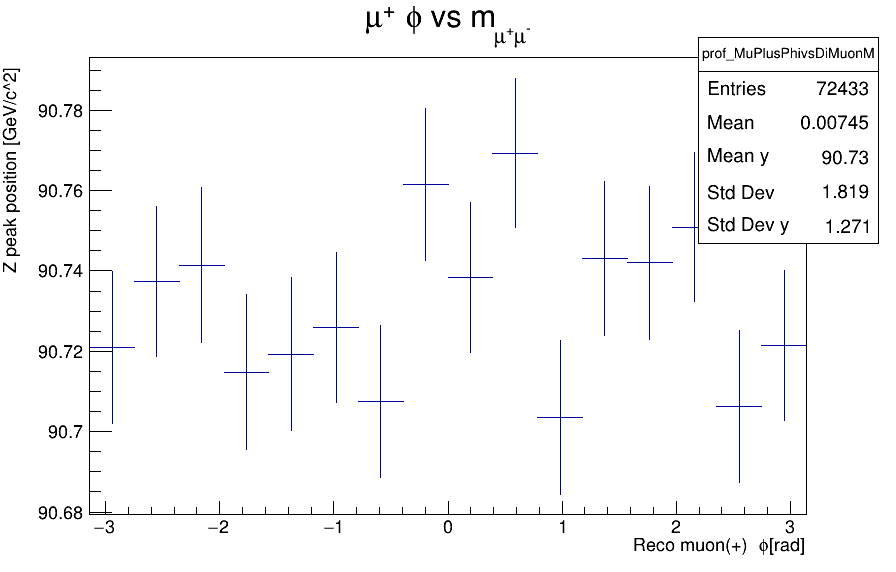

In [57]:
c3.Draw()

In [58]:
mum_phi=ak.flatten(two_opposite_good_muons.muon_phi[two_opposite_good_muons.muon_charge<0],axis=None)
prof_MuMinusPhivsDiMuonM = ROOT.TProfile("prof_MuMinusPhivsDiMuonM","#mu^{-} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(-) #phi[rad];Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

In [59]:
for phi, m in zip(mum_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuMinusPhivsDiMuonM.Fill(phi, m, 1)

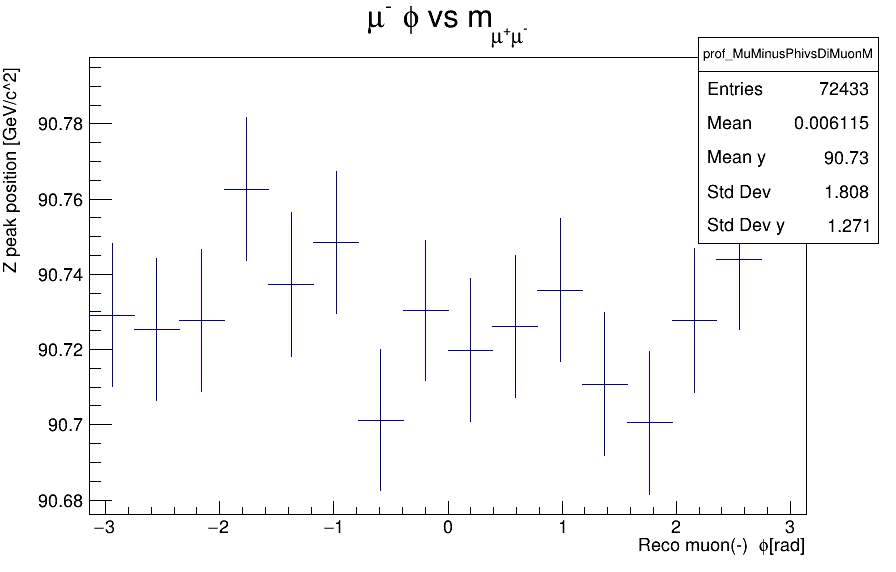

In [60]:
c4 = ROOT.TCanvas("mumphidimum","",900,600)
prof_MuMinusPhivsDiMuonM.Draw()
c4.Draw()

In [61]:
prof_MuEtavsDiMuonM = ROOT.TProfile("prof_MuEtavsDiMuonM","Muon #eta vs m_{#mu^{+}#mu^{-}};Reco Muon #eta; Z peak position [GeV/c^2]",50,-2.4,2.4,88,93)

In [62]:
for eta1, eta2, m in zip(two_opposite_good_muons[dimuon_mass_mask].muon_eta[:,0],
                         two_opposite_good_muons[dimuon_mass_mask].muon_eta[:,0],
                         dimuon_p4.mass[dimuon_mass_mask]):
    prof_MuEtavsDiMuonM.Fill(eta1, m, 1)
    prof_MuEtavsDiMuonM.Fill(eta2, m, 1)
    

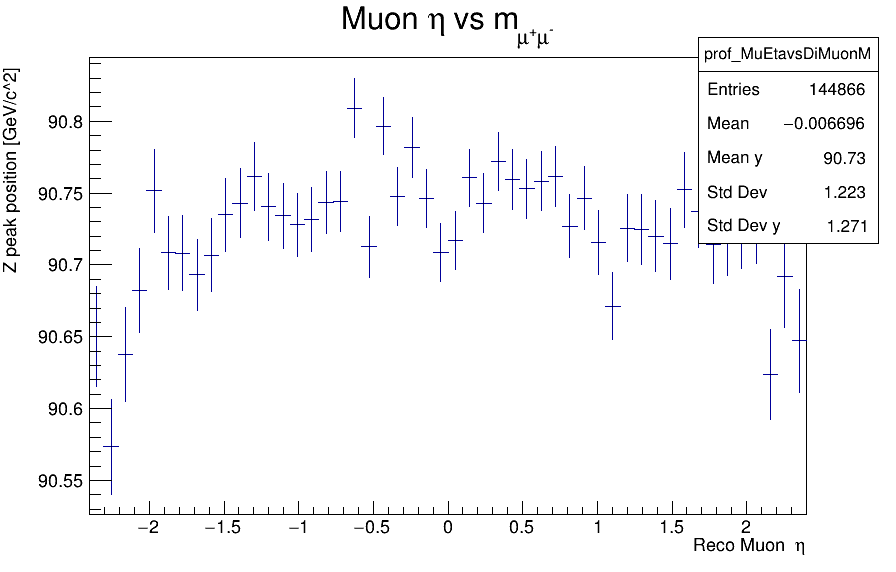

In [63]:
c5 = ROOT.TCanvas("muetadimum","",900,600)
prof_MuEtavsDiMuonM.Draw()
c5.Draw()

**Questions 2:**
   * What do they look like? Is the reconstructed mass flat _vs_ &phi; and &eta; or are there deviations? 
   * Are the deviations compatible with statistical fluctuations or do you notice a trend? 
   * What could explain this behavior?


# Step 3: Investigate the muon transverse momentum resolution

Now we will study the muon transverse momentum resolution. We will consider distributions of the transverse momentum residuals, defined as  R(1/pT) = (1/pT<sup>REC</sup> &ndash; 1/pT<sup>GEN</sup>)/(1/pT<sup>GEN</sup>). In the ideal case, the distribution of the residuals is expected to be Gaussian and its standard deviation is the pT resolution. Likewise, we can define the dimuon invariant mass residuals as R(M) = (M<sup>REC</sup> &ndash; M<sup>GEN</sup>)/M<sup>GEN</sup>, and the standard deviation of the R(M) distribution defines the mass resolution. 

We will create the following histograms:
   * 1D histogram of the muon transverse momentum residuals R(1/PT): A histogram (h_MupTRes) of the muon transverse momentum residual using the PAT muons and GEN muons. Fit this distribution to a Gaussian function. The fit parameter sigma gives the muon transverse momentum resolution in the chosen p<sub>T</sub> range.
   * 1D histogram of the dimuon invariant mass residuals R(M): A histogram (h_MassRes) for the invariant mass resolution residual, which is defined as (M<sub>rec</sub> - M<sub>gen</sub> )/M<sub>gen</sub>. Fit this distribution to a Gaussian.
   * Profile histograms (prof_MupTvspTRes and prof_MuEtavspTRes) of muon transverse momentum residuals  as a function of muon pT and &eta;.
Note that, by default, a [TProfile](http://root.cern.ch/root/html/TProfile.html) will display in each bin the <span style='color:red'> mean value $\pm$ mean value error </span> (i.e. RMS/$\sqrt(N)$). Initializing the [TProfile](http://root.cern.ch/root/html/TProfile.html)  with option "s" instead, it will display <span style='color:red'> mean value $\pm$ RMS </span>. This is more useful for us, as the RMS estimates the standard deviation, i.e. the resolution of each bin. 

Text(0, 0.5, 'Events')

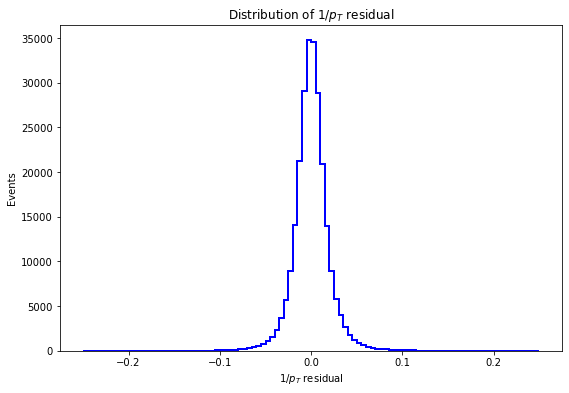

In [65]:
pt_res=ak.flatten(two_opposite_good_muons.genpart_pt,axis=-1)/ak.flatten(two_opposite_good_muons.muon_pt,axis=-1)-1
plt.figure(figsize=(9,6))
plt.hist(pt_res, bins=100, range=[-0.25,0.25], histtype='step',linewidth=2, color='blue', label='$1/p_T$ residual')
#plt.legend()
plt.title('Distribution of $1/p_T$ residual')
plt.xlabel('$1/p_T$ residual')
plt.ylabel('Events')

In [68]:
mass_res=ak.flatten(dimuon_p4.mass,axis=None)/ak.flatten(gen_dimuon_p4.mass,axis=None)-1

Text(0, 0.5, 'Events')

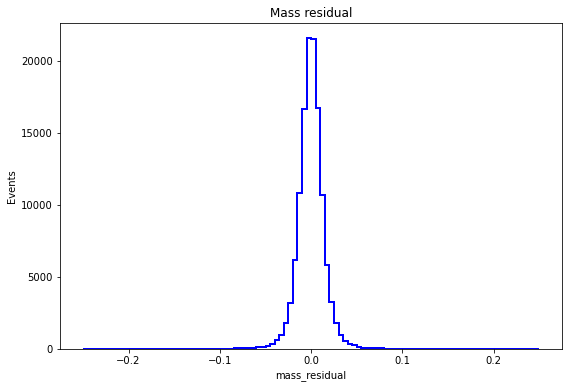

In [69]:
plt.figure(figsize=(9,6))
plt.hist(mass_res, bins=100, range=[-0.25,0.25], histtype='step', linewidth=2, color='blue', label='mass_residual')
#plt.legend()
plt.title('Mass residual')
plt.xlabel('mass_residual')
plt.ylabel('Events')

 FCN=11639.6 FROM MIGRAD    STATUS=CONVERGED      75 CALLS          76 TOTAL
                     EDM=3.33419e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.06099e+04   8.97542e+01   3.29542e+00  -3.27229e-07
   2  Mean         3.77340e-05   3.19145e-05   1.68011e-06   8.04180e+00
   3  Sigma        1.56050e-02   3.28051e-05   2.26351e-05  -1.45414e-02


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

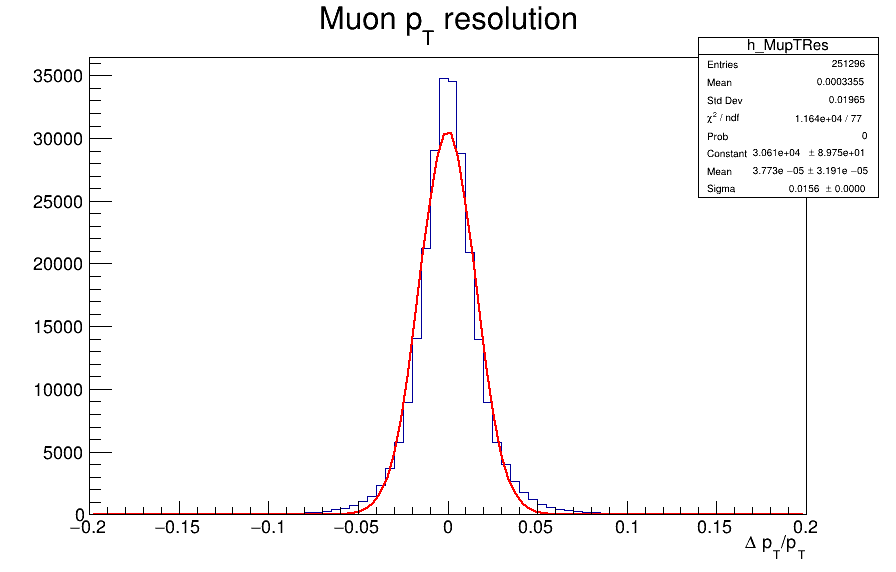

In [70]:
c6 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c6.Draw()
h_MupTRes.Fit("gaus")

 FCN=4197.75 FROM MIGRAD    STATUS=CONVERGED      76 CALLS          77 TOTAL
                     EDM=7.89601e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.50386e+04   5.98272e+01   1.36675e+00   8.63582e-09
   2  Mean        -9.19977e-05   3.46316e-05   1.09572e-06   6.73955e-02
   3  Sigma        1.20560e-02   3.31733e-05   1.87289e-05   4.34499e-03


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

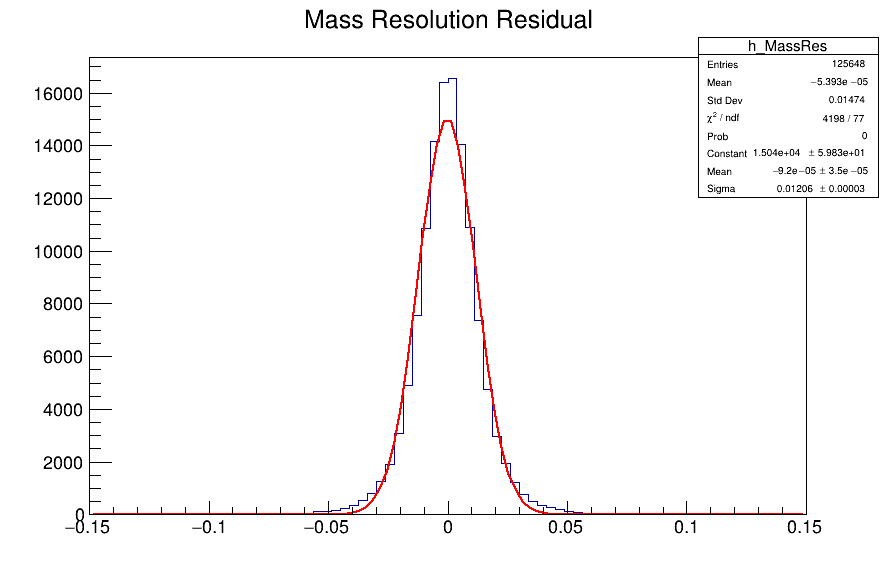

In [71]:
c7 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    h_MassRes.Fill(res)
h_MassRes.Draw()
c7.Draw()
h_MassRes.Fit("gaus")

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuEtavspTRes (Potential memory leak).


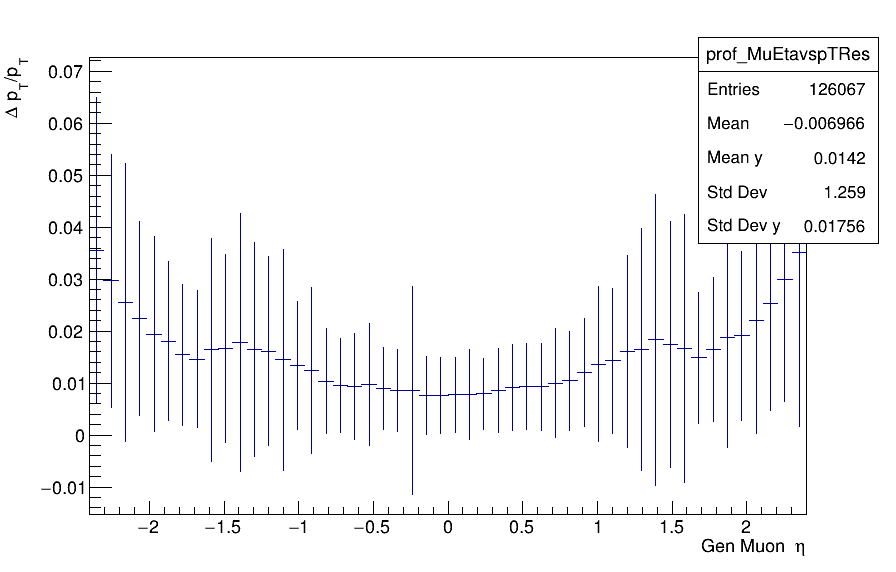

In [73]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1,'s')
for ptres, eta in zip(pt_res, ak.flatten(two_gen_muon_p4.eta,axis=None)):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c8 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c8.Draw()

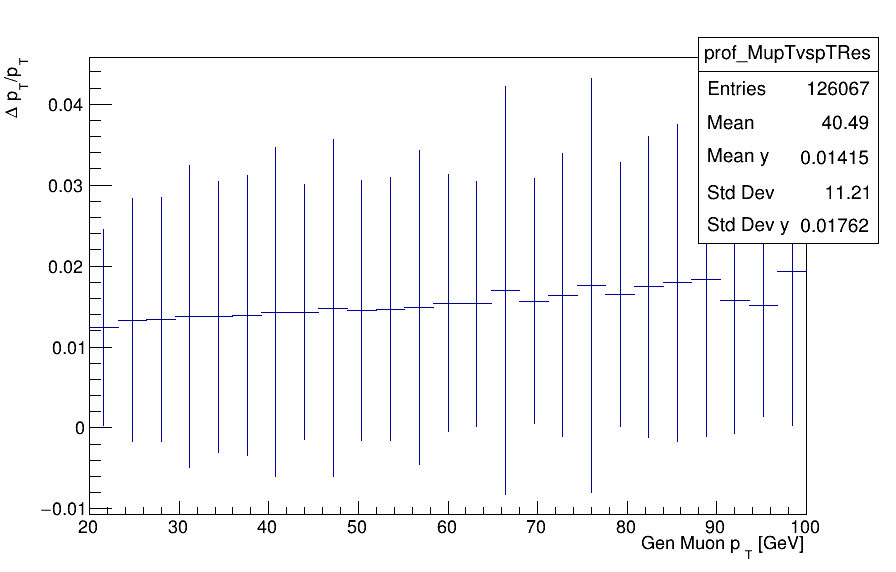

In [74]:
prof_MupTvspTRes = ROOT.TProfile("prof_MupTvspTRes",";Gen Muon p_{T} [GeV];#Delta p_{T}/p_{T}",25,20,100,0,1,'s')
for ptres, pt in zip(pt_res, ak.flatten(two_gen_muon_p4.pt,axis=None)):
    prof_MupTvspTRes.Fill(pt, ptres, 1)
c9 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c9.Draw()

**Questions 3**:
* What is the typical 1/pT resolution of a 50 GeV muon measured in the CMS detector?
* How does the 1/pT resolution scale with transverse momentum? And with the pseudorapidity?
* Why is the mass residual not a perfect Gaussian distribution?
* How is the 1/pT resolution related to the invariant mass resolution?

# Step 4: Momentum scale corrections

As mentioned in the introduction, small biases in the muon momentum measurement can be recovered by applying specific corrections. In CMS we have several algorithms to compute such corrections to the momentum scale and/or resolution. They are documented in this MUO POG [TWiki page](https://twiki.cern.ch/twiki/bin/view/CMS/MuonReferenceScaleResolRun2). In the following, we will demonstrate the use of one of these correction strategies, called _Rochester algorithm_. The details of the algorithm and how it computes the corrections are beyond the goals of this exercise. Suffice it to say that it extracts correction factors by "forcing" muons from (mostly) Z&rarr;&mu;&mu; decays to coincide with reference distributions obtained from Monte Carlo generated muons. For more details, check out  [EPJC V72, 10.2194 (2012)](https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-012-2194-8) [arXiv:1208.3710](https://arxiv.org/abs/1208.3710) or the link above.


First download the rochester method python(RoccoR.py) implemetnion from GitHub, which is used in UWCMS final state analysis

In [75]:
import os
os.system('wget https://raw.githubusercontent.com/uwcms/FinalStateAnalysis/d4fa28eecdb41575039b6cb760dd11604f796a4b/PatTools/python/RoccoR.py')

0

--2021-06-28 16:24:15--  https://raw.githubusercontent.com/uwcms/FinalStateAnalysis/d4fa28eecdb41575039b6cb760dd11604f796a4b/PatTools/python/RoccoR.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14146 (14K) [text/plain]
Saving to: ‘RoccoR.py’

     0K .......... ...                                        100% 78.4M=0s

2021-06-28 16:24:15 (78.4 MB/s) - ‘RoccoR.py’ saved [14146/14146]



In [76]:
import RoccoR

Loading the 2018 run II correction file

In [77]:
rc=RoccoR.RoccoR('/cms/store/user/hats/Muon/RoccoR2018.txt')
#rc=RoccoR.RoccoR('RoccoR2018.txt')

In [79]:
random=np.random.rand(len(ak.flatten(muon.muon_eta)))

In [80]:
two_opposite_good_muons.muon_pt

<Array [[50.7, 35], [53.9, ... [30.6, 25.6]] type='125648 * var * float32'>

In [81]:
rnd=ROOT.TRandom3(1234)

Now, write a loop to correct each muon one by one, and then repeat step 2 and 3

In [82]:
cor_pt=[]
cor_eta=[]
cor_phi=[]
for row in two_opposite_good_muons:
    cor_pt_1=[]
    cor_eta_1=[]
    cor_phi_1=[]
    for charge, pt, eta, phi, ntracker, genpt  in zip(row.muon_charge, row.muon_pt, row.muon_eta, row.muon_phi, row.muon_ntrackerlayers, row.genpart_pt):
        musf=rc.kScaleFromGenMC(charge, pt, eta, phi, ntracker, genpt, rnd.Rndm(), 0, 0)
        cor_pt_1.append(pt*musf)
        cor_eta_1.append(eta*musf)
        cor_phi_1.append(phi*musf)
    cor_pt.append(cor_pt_1)
    cor_eta.append(cor_eta_1)
    cor_phi.append(cor_phi_1)        

In [122]:
scaled_two_opposite_good_muons=ak.Array(ak.zip({"muon_pt": ak.Array(cor_pt), 
                                                  "muon_eta": ak.Array(cor_eta),
                                                  "muon_phi": ak.Array(cor_phi),
                                                  "muon_mass": two_opposite_good_muons.muon_mass,
                                                  "muon_charge": two_opposite_good_muons.muon_charge,
                                                  "genpart_pt": two_opposite_good_muons.genpart_pt,
                                                  "genpart_eta": two_opposite_good_muons.genpart_eta,
                                                  "genpart_phi": two_opposite_good_muons.genpart_phi,
                                                  "genpart_mass": two_opposite_good_muons.genpart_mass,}))
scaled_two_opposite_good_muons

<Array [[{muon_pt: 50.7, ... genpart_mass: 0}]] type='125648 * var * {"muon_pt":...'>

In [123]:
uncorrected_two_opposite_good_muons= two_opposite_good_muons
two_opposite_good_muons=scaled_two_opposite_good_muons

In [124]:
two_muon_p4 = ak.Array(ak.zip({"pt":two_opposite_good_muons.muon_pt, 
                               "eta":two_opposite_good_muons.muon_eta, 
                               "phi":two_opposite_good_muons.muon_phi, 
                               "mass":two_opposite_good_muons.muon_mass}), with_name="Momentum4D")

In [125]:
dimuon_p4=two_muon_p4[:,0]+two_muon_p4[:,1]
#dimuon_p4.mass

In [126]:
dimuon_mass_mask=(dimuon_p4.mass>70)&(dimuon_p4.mass<110)

Text(0, 0.5, 'Events')

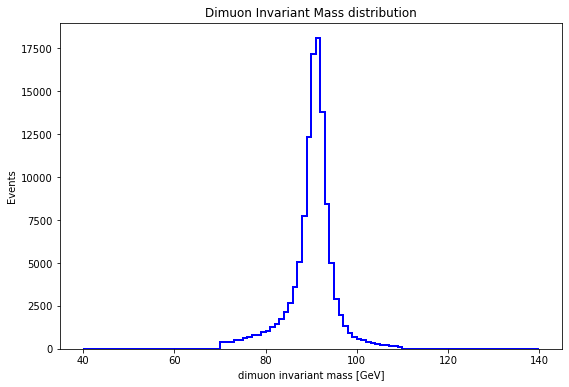

In [127]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4.mass[dimuon_mass_mask], bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

In [129]:
two_gen_muon_p4 = ak.Array(ak.zip({"pt":two_opposite_good_muons.genpart_pt, 
                               "eta":two_opposite_good_muons.genpart_eta, 
                               "phi":two_opposite_good_muons.genpart_phi, 
                               "mass":two_opposite_good_muons.genpart_mass}), with_name="Momentum4D")

In [130]:
gen_dimuon_p4=two_gen_muon_p4[:,0]+two_gen_muon_p4[:,1]

In [131]:
gen_dimuon_p4.mass

<Array [96.2, 93.6, 92.8, ... 93.4, 92, 90.6] type='125648 * float32'>

Text(0, 0.5, 'Events')

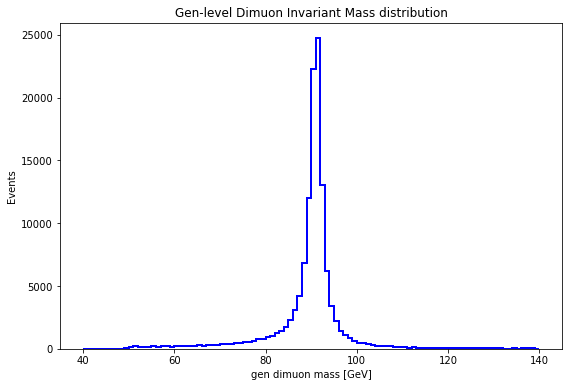

In [132]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
#plt.legend()
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

 FCN=486.789 FROM MIGRAD    STATUS=CONVERGED     188 CALLS         189 TOTAL
                     EDM=2.83319e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.89595e+04   1.99220e+02   2.03580e+00  -4.00624e-07
   2  p1           9.10283e+01   5.84779e-03   6.24961e-05  -3.10652e-02
   3  p2           2.79950e+00   1.50550e-02   1.52673e-04  -8.96550e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: gendimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_GenDiMuonM (Potential memory leak).


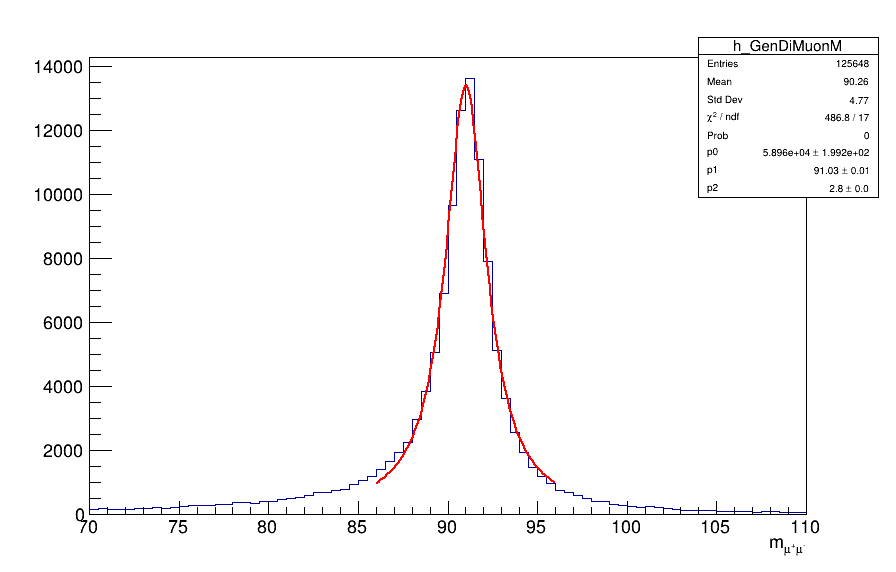

In [133]:
c10 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c10.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c10.Draw()

 FCN=188.931 FROM MIGRAD    STATUS=CONVERGED     327 CALLS         328 TOTAL
                     EDM=2.01551e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.08311e+04   3.26681e+02   1.33480e+00   2.24686e-07
   2  p1           9.10621e+01   8.75154e-03   5.86728e-05  -2.02508e-02
   3  p2           7.40565e-01   5.02628e-02   1.23217e-04   2.88354e-03
   4  p3           3.67037e+00   6.77090e-02   1.45716e-04   5.06307e-04


Warning in <TCanvas::Constructor>: Deleting canvas with same name: recdimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_RecDiMuonM (Potential memory leak).


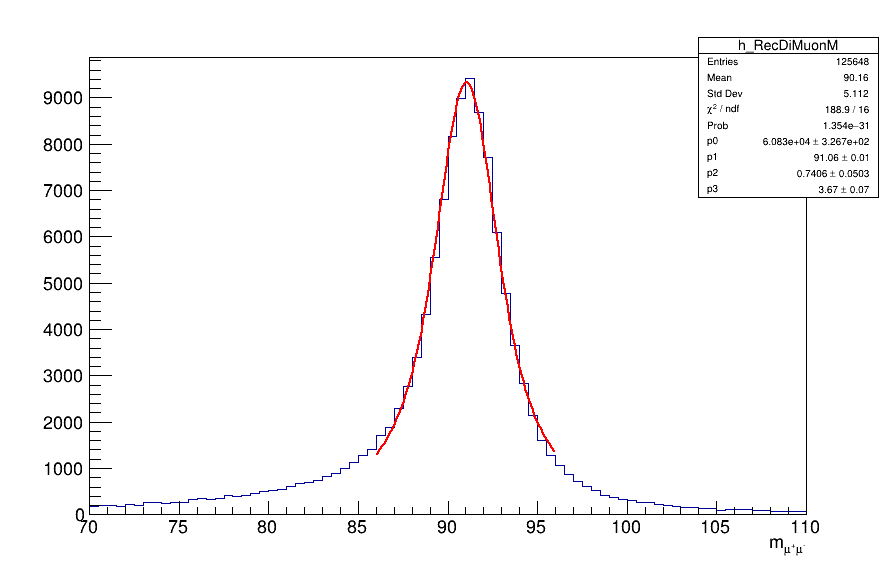

In [134]:
c11 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in dimuon_p4.mass:
    h_RecDiMuonM.Fill(m)
h_RecDiMuonM.Draw()
c11.Draw()
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c11.Draw()
#h_RecDiMuonM.Fit("gaus","","", 86., 96.)

In [135]:
prof_MuPlusPhiVsDiMuonM=ROOT.TProfile("prof_MuPlusPhivsDiMuonM","#mu^{+} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(+) #phi[rad]; Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuPlusPhivsDiMuonM (Potential memory leak).


In [137]:
mup_phi=ak.flatten(two_opposite_good_muons.muon_phi[two_opposite_good_muons.muon_charge>0])

In [138]:
for phi, m in zip(mup_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuPlusPhiVsDiMuonM.Fill(phi, m, 1)

In [139]:
c12 = ROOT.TCanvas("mupphidimum","",900,600)
prof_MuPlusPhiVsDiMuonM.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: mupphidimum


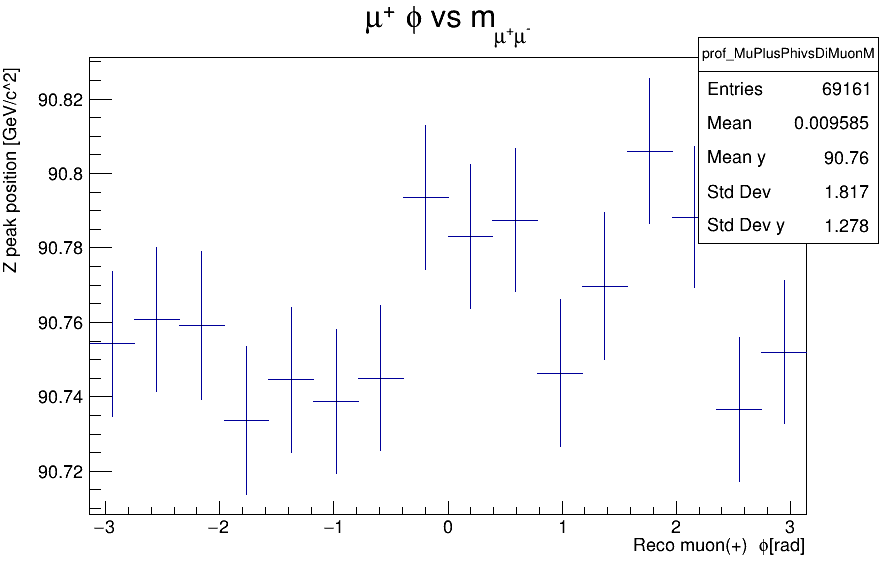

In [140]:
c12.Draw()

In [141]:
mum_phi=two_opposite_good_muons.muon_phi[two_opposite_good_muons.muon_charge<0].flatten()
prof_MuMinusPhivsDiMuonM = ROOT.TProfile("prof_MuMinusPhivsDiMuonM","#mu^{-} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(-) #phi[rad];Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

AttributeError: no field named 'flatten'

(https://github.com/scikit-hep/awkward-1.0/blob/1.3.0/src/awkward/highlevel.py#L1120)

In [142]:
for phi, m in zip(mum_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuMinusPhivsDiMuonM.Fill(phi, m, 1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: mumphidimum


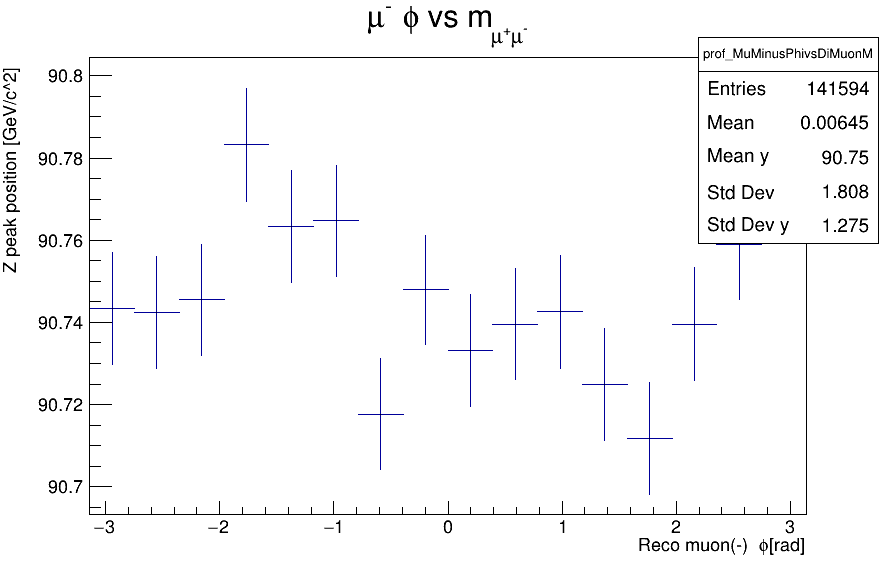

In [143]:
c13 = ROOT.TCanvas("mumphidimum","",900,600)
prof_MuMinusPhivsDiMuonM.Draw()
c13.Draw()

In [144]:
prof_MuEtavsDiMuonM = ROOT.TProfile("prof_MuEtavsDiMuonM","Muon #eta vs m_{#mu^{+}#mu^{-}};Reco Muon #eta; Z peak position [GeV/c^2]",50,-2.4,2.4,88,93)

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuEtavsDiMuonM (Potential memory leak).


In [145]:
for eta1, eta2, m in zip(two_opposite_good_muons[dimuon_mass_mask].muon_eta[:,0],
                         two_opposite_good_muons[dimuon_mass_mask].muon_eta[:,0],
                         dimuon_p4.mass[dimuon_mass_mask]):
    prof_MuEtavsDiMuonM.Fill(eta1, m, 1)
    prof_MuEtavsDiMuonM.Fill(eta2, m, 1)
    

Warning in <TCanvas::Constructor>: Deleting canvas with same name: muetadimum


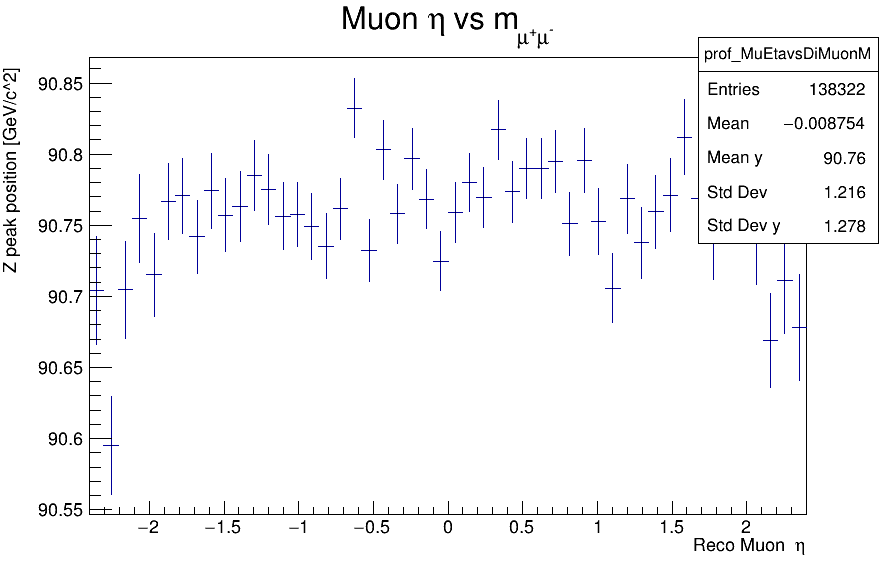

In [146]:
c14 = ROOT.TCanvas("muetadimum","",900,600)
prof_MuEtavsDiMuonM.Draw()
c14.Draw()

Text(0, 0.5, 'Events')

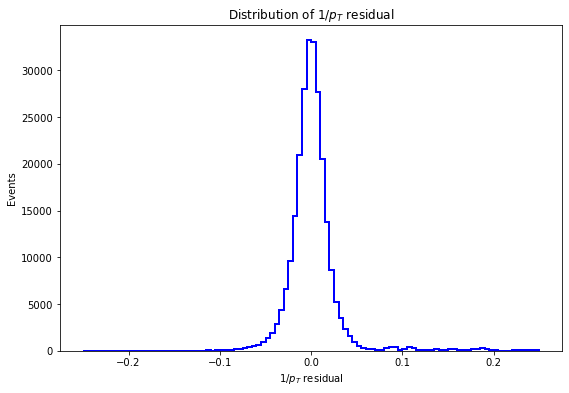

In [148]:
pt_res=ak.flatten(two_opposite_good_muons.genpart_pt)/ak.flatten(two_opposite_good_muons.muon_pt)-1
plt.figure(figsize=(9,6))
plt.hist(pt_res, bins=100, range=[-0.25,0.25], histtype='step',linewidth=2, color='blue', label='$1/p_T$ residual')
#plt.legend()
plt.title('Distribution of $1/p_T$ residual')
plt.xlabel('$1/p_T$ residual')
plt.ylabel('Events')

In [151]:
mass_res=ak.flatten(dimuon_p4.mass,axis=None)/ak.flatten(gen_dimuon_p4.mass,axis=None)-1

Text(0, 0.5, 'Events')

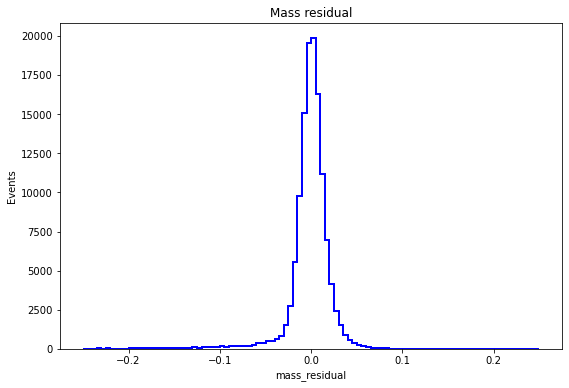

In [152]:
plt.figure(figsize=(9,6))
plt.hist(mass_res, bins=100, range=[-0.25,0.25], histtype='step', linewidth=2, color='blue', label='mass_residual')
#plt.legend()
plt.title('Mass residual')
plt.xlabel('mass_residual')
plt.ylabel('Events')

 FCN=14145.9 FROM MIGRAD    STATUS=CONVERGED      94 CALLS          95 TOTAL
                     EDM=2.997e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.92691e+04   8.59570e+01   3.49840e+00   8.32573e-07
   2  Mean        -6.32789e-04   3.32300e-05   1.92306e-06  -1.10126e+00
   3  Sigma        1.60883e-02   3.36933e-05   2.17992e-05   1.75803e-01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: ptresidual
Warning in <TROOT::Append>: Replacing existing TH1: h_MupTRes (Potential memory leak).
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error i

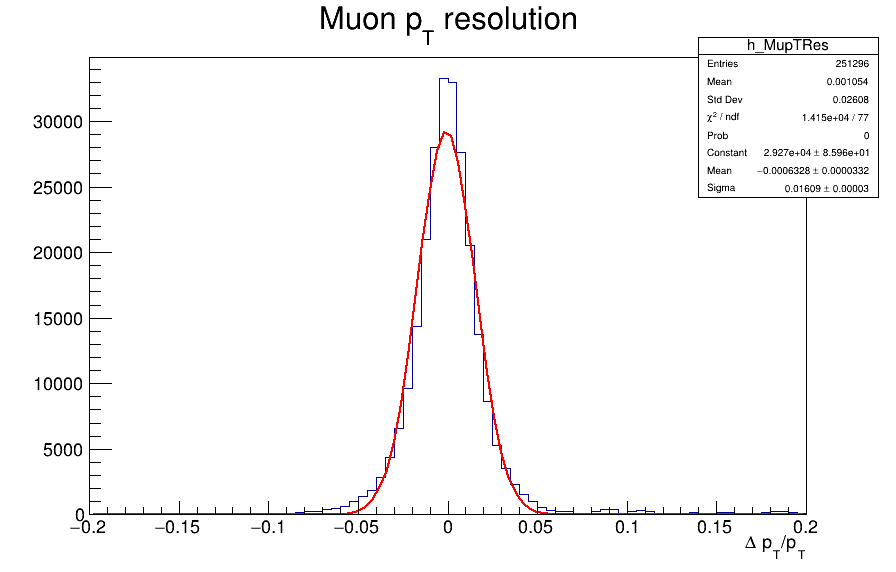

In [153]:
c16 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c16.Draw()
h_MupTRes.Fit("gaus")

 FCN=7477.3 FROM MIGRAD    STATUS=CONVERGED      91 CALLS          92 TOTAL
                     EDM=1.74164e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.36968e+04   5.57237e+01   1.68862e+00  -5.06264e-06
   2  Mean         1.17773e-03   3.77497e-05   1.57965e-06   6.09607e+00
   3  Sigma        1.28118e-02   3.62845e-05   2.20424e-05   3.80368e-01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: massresidual
Warning in <TROOT::Append>: Replacing existing TH1: h_MassRes (Potential memory leak).
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error

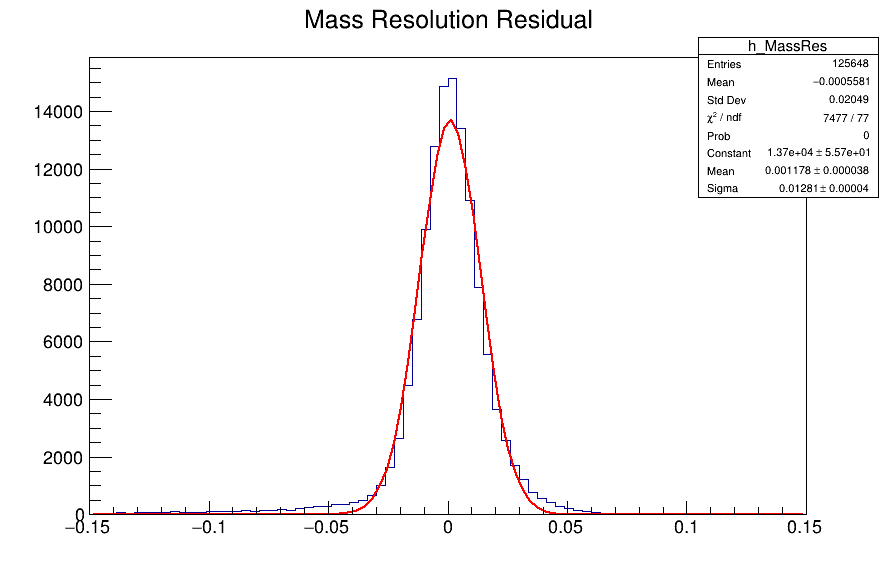

In [154]:
c17 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    h_MassRes.Fill(res)
h_MassRes.Draw()
c17.Draw()
h_MassRes.Fit("gaus")

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuEtavspTRes (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: muetavsptres


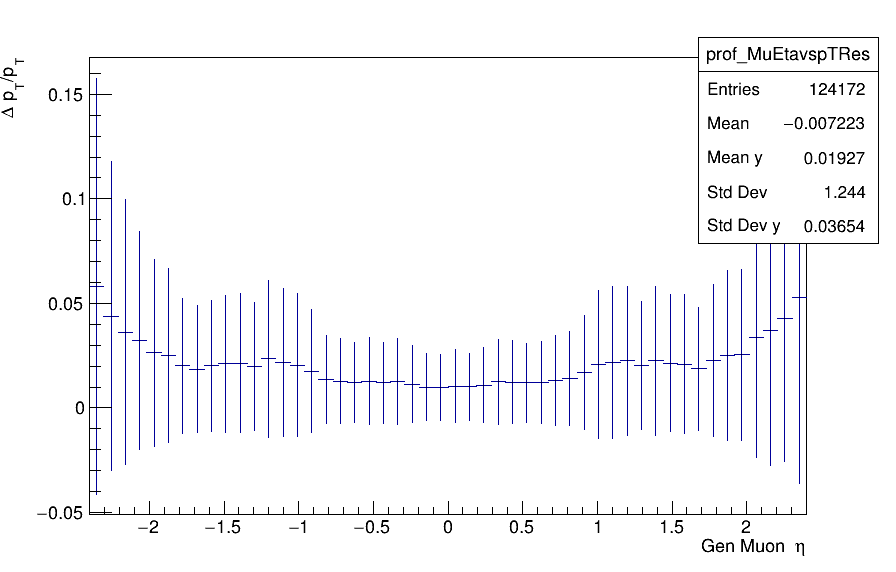

In [156]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1,'s')
for ptres, eta in zip(pt_res, ak.flatten(two_gen_muon_p4.eta)):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c18 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c18.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: prof_MupTvspTRes (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: muptvsptres


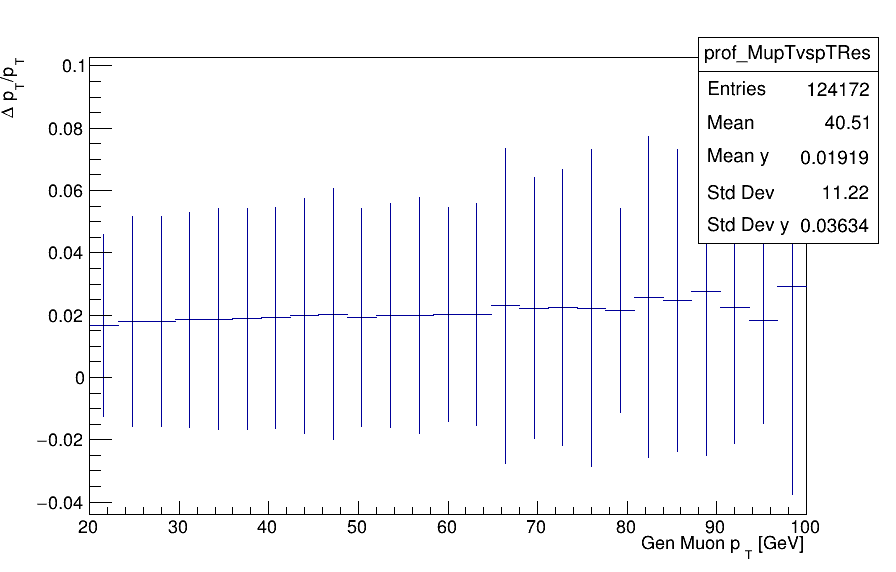

In [157]:
prof_MupTvspTRes = ROOT.TProfile("prof_MupTvspTRes",";Gen Muon p_{T} [GeV];#Delta p_{T}/p_{T}",25,20,100,0,1,'s')
for ptres, pt in zip(pt_res, ak.flatten(two_gen_muon_p4.pt)):
    prof_MupTvspTRes.Fill(pt, ptres, 1)
c19 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c19.Draw()

**Questions 4:**
   * Describe the main differences that you observe between the uncorrected and corrected distributions. 
   * Does the corrected mass spectrum get closer to the generated mass spectrum, and the peak closer to the PDG value? 
   * Do the corrections help restore a flat distribution of the dimuon mass _vs_ &phi; and &eta;? 
   * How did the resolution change after the corrections? How would you explain it? 